# Content

- Preparation
- Learning rate decay
- Part1. Resnet
    - Skip connection
    - Import resnet
    - Training
    - Load and test
    - Classfication report
    - Load pretrained model

- Part2. Building Blocks
    - Objective
    - Start with small block
    - Build bigger model
    - Classifier
    - Final Model(VGG13)
    - Summarize

# Preparation

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.nn import CrossEntropyLoss
from torchvision.datasets import CIFAR10

In [2]:
# For reproducibility
seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

trainset = CIFAR10(root='./cifar10', train=True, transform=transform, download=True)
validset = CIFAR10(root='./cifar10', train=True, transform=transform)
testset = CIFAR10(root='./cifar10', train=False, transform=transform)

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [4]:
# Train set, validation set split
from sklearn.model_selection import train_test_split # tabular data 

train_idx, valid_idx = train_test_split(np.arange(len(trainset)), test_size=0.1,
                                        random_state=42, shuffle=True, stratify=trainset.targets)


from multiprocessing import cpu_count
batch_size = 1000
num_workers = int(cpu_count() / 2)

train_loader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx),
                          num_workers=num_workers)
valid_loader = DataLoader(validset, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx),
                          num_workers=num_workers)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=num_workers)

In [5]:
# Device setting
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Learning rate decay

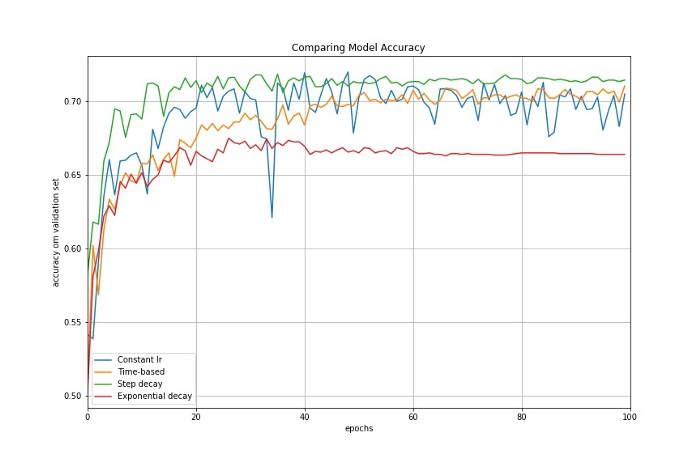

In [6]:
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, verbose=True)

In [7]:
# optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1, verbose=False)

# Part1. Resnet


[Deep Residual Learning for Image Recognition] https://arxiv.org/abs/1512.03385


## Skip connection

In [8]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out) # residual
        print(out.shape)
        print(identity.shape)
        out += identity  # should be same size
        out = self.relu(out)

        return out

In [9]:
input = torch.randn(16, 3, 32, 32)

In [10]:
model = BasicBlock(in_channels = 3, out_channels = 16) # input, output

In [ ]:
model(input).shape

## import Resnet

In [21]:
from torchvision.models import resnet18 as resnet

## Training

In [22]:
model = resnet().to(device) # initialized 

criterion = CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.1, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, verbose=True)

In [23]:
train_total = len(train_idx)
valid_total = len(valid_idx)

train_batches = len(train_loader)
valid_batches = len(valid_loader)

# Variables for lr scheduling and early stopping
best_valid_loss = 1024    # Any large number will suffice
patience = 0    # Bad epoch counter

In [24]:
# # %%time

# for epoch in range(100):
#     # Train
#     model.train()
    
#     train_loss = 0
#     train_correct = 0
    
#     for x, y in train_loader:
#         x = x.to(device)
#         y = y.to(device)
#         outputs = model(x)
#         loss = criterion(outputs, y)
        
#         optimizer.zero_grad()
        
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
#         _, predicted = outputs.max(1)
#         train_correct += predicted.eq(y).sum().item()
        
#     train_loss = train_loss / train_batches
#     train_acc = train_correct / train_total
    
#     # Validate
#     model.eval()
    
#     valid_loss = 0
#     valid_correct = 0
    
#     with torch.no_grad():
#         for x, y in valid_loader:
#             x = x.to(device)
#             y = y.to(device)
#             outputs = model(x)
#             loss = criterion(outputs, y)
            
#             valid_loss += loss.item()
#             _, predicted = outputs.max(1)
#             valid_correct += predicted.eq(y).sum().item()
            
#     valid_loss = valid_loss / valid_batches
#     valid_acc = valid_correct / valid_total
    
#     # Save best model
#     if best_valid_loss > valid_loss:
#         torch.save(model.state_dict(), './best_resnet.pth')
#         best_valid_loss = valid_loss
#         patience = 0
        
#     print('[%2d] TRAIN loss: %.3f, acc: %.3f, lr: %f .... VALID loss: %.3F, acc: %.3f, best_loss: %.3f .... PATIENCE %d' 
#           % (epoch+1, train_loss, train_acc, optimizer.param_groups[0]['lr'], valid_loss, valid_acc, best_valid_loss, patience))
    
#     scheduler.step(metrics=valid_loss) # adjust learning rate (decay)
    
#     # Break training loop if no improvement for 5 consecutive epochs
#     if patience == 5:
#         break
        
#     patience += 1

## load and test

In [25]:
# # Load best model
# loaded = resnet().to(device) # initialized again 
# loaded.load_state_dict(torch.load('./best_resnet.pth'))  # change model parameter to what your saved parameter is

In [26]:
# %%time

# # Test
# loaded.eval()

# test_loss = 0
# test_correct = 0

# with torch.no_grad():
#     for i, (x, y) in enumerate(test_loader):
#         x = x.to(device)
#         y = y.to(device)
#         outputs = loaded(x)
#         loss = criterion(outputs, y)
        
#         test_loss += loss.item()
#         _, predicted = outputs.max(1)
#         test_correct += predicted.eq(y).sum().item()
        
#         if i == 0:
#             test_preds = predicted
#         else:
#             test_preds = torch.cat((test_preds, predicted), dim=0)
            
# test_preds = test_preds.cpu()

# print('TEST loss: %.4f, acc: %.4f' % (test_loss/len(test_loader), test_correct/len(testset)))

## classification report


In [27]:
from sklearn.metrics import classification_report

In [28]:
# print(classification_report(testset.targets, test_preds, target_names=testset.classes))

In [29]:
# accuracy = correct prediction / the number of data
# 1000 data
# 10 - class 1
# 990 - class 0

# goal is to predict class 1

# your model predict every data s class 0
# 990 correct / 1000 = 99% 

## Load pretrained model

In [30]:
# Get pre-trained model (with ImageNet)
pretrained = resnet(pretrained=True) 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


# Part2. Building Blocks


## Objective

- Build VGG13 as described in the paper.
- Use non-linear activattion (ReLU) at each conv or fc layers


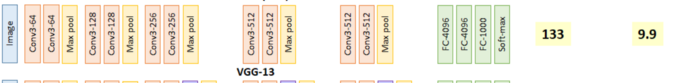

In [31]:
# class VGG13(nn.Module):
#     def __init__()
#         self.layer1 = nn.Sequential()
#         .
#         .
#         .

#     def forward


    

## Start with small blocks

In [32]:
class SmallBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SmallBlock, self).__init__()
        self.layer = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
    def forward(self, x):
        return self.layer(x)

In [33]:
input = torch.randn(4, 3, 32, 32)

In [34]:
model = SmallBlock(3, 64)
print(model(input).shape)

torch.Size([4, 64, 16, 16])


## Build bigger model

In [35]:
configurations = [3, 64, 128, 256, 512, 512] # shows model design

In [36]:
class VGG13_CNN(nn.Module):
    def __init__(self, cfgs):
        super(VGG13_CNN, self).__init__()
        self.bigger_block = nn.Sequential(SmallBlock(cfgs[0], cfgs[1]),
                                    SmallBlock(cfgs[1], cfgs[2]),
                                    SmallBlock(cfgs[2], cfgs[3]),
                                    SmallBlock(cfgs[3], cfgs[4]),
                                    SmallBlock(cfgs[4], cfgs[5]))

    def forward(self, x):                    # batch_size, 3, 224, 224
        return self.bigger_block(x)         # batch_size, 512, 7, 7

In [37]:
input = torch.randn(4, 3, 224, 224)

In [38]:
model = VGG13_CNN(configurations)

In [39]:
model(input).shape

torch.Size([4, 512, 7, 7])

## Classifier

In [48]:
class VGG13_Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG13_Classifier, self).__init__()
        self.pooling = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x): # [batch_size, 512, 7, 7]
        x = self.pooling(x)
        x = torch.flatten(x, 1) # batch_size x 512 x 7 x 7
        x = self.classifier(x)
        return x  # batch_size, num_classes

## Final Model(VGG13)

In [49]:
class VGG13(nn.Module):
    def __init__(self, cfgs, num_classes=10):
        super(VGG13, self).__init__()
        self.cnn = VGG13_CNN(cfgs)
        self.classifier = VGG13_Classifier(num_classes)
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.classifier(x)
        return x

In [50]:
model = VGG13(configurations)

In [ ]:
model.to("cpu")

In [51]:
model(input).shape

torch.Size([4, 10])

## Summarize the model

In [54]:
model

VGG13(
  (cnn): VGG13_CNN(
    (bigger_block): Sequential(
      (0): SmallBlock(
        (layer): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): SmallBlock(
        (layer): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (2): SmallBlock(
        (layer): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inpl

In [52]:
from torchsummary import summary

In [53]:
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
        SmallBlock-6         [-1, 64, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]          73,856
              ReLU-8        [-1, 128, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]         147,584
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
       SmallBlock-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         295,168
             ReLU-14          [-1, 256,